# Prepare data

In [ ]:
import json
import os

# Read json annotations
with open('../data/train/_annotations.coco.json') as f:
    train_annotations = json.load(f)
with open('../data/valid/_annotations.coco.json') as f:
    valid_annotations = json.load(f)
with open('../data/test/_annotations.coco.json') as f:
    test_annotations = json.load(f)

train_annotations.keys()

In [ ]:
train_annotations['categories']

In [ ]:
import pandas as pd
import cv2

# Create dataframes out of annotations
df_train = pd.DataFrame(train_annotations['annotations'])
df_train['file_name'] = [file_name['file_name'] for file_name in train_annotations['images']]
df_test = pd.DataFrame(test_annotations['annotations'])
df_test['file_name'] = [file_name['file_name'] for file_name in test_annotations['images']]
df_valid = pd.DataFrame(valid_annotations['annotations'])
df_valid['file_name'] = [file_name['file_name'] for file_name in valid_annotations['images']]

df_train.head()

In [ ]:
import torch

# Define the target size
target_size = (128, 128)

# Read and normalize train images
train_images = torch.zeros((len(df_train['file_name']), 1, *target_size), dtype=torch.float32)
for i, file_name in enumerate(df_train['file_name']):
    img = cv2.imread('../data/train/' + file_name, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, target_size)  # Resize to 128x128
    train_images[i][0] = torch.tensor(img_resized, dtype=torch.float32) / 255.0  # Normalize

# Read and normalize test images
test_images = torch.zeros((len(df_test['file_name']), 1, *target_size), dtype=torch.float32)
for i, file_name in enumerate(df_test['file_name']):
    img = cv2.imread('../data/test/' + file_name, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, target_size)  # Resize to 128x128
    test_images[i][0] = torch.tensor(img_resized, dtype=torch.float32) / 255.0  # Normalize

# Read and normalize valid images
valid_images = torch.zeros((len(df_valid['file_name']), 1, *target_size), dtype=torch.float32)
for i, file_name in enumerate(df_valid['file_name']):
    img = cv2.imread('../data/valid/' + file_name, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, target_size)  # Resize to 128x128
    valid_images[i][0] = torch.tensor(img_resized, dtype=torch.float32) / 255.0  # Normalize


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the target size
target_size = (128, 128)

# Plot some examples
fig, axs = plt.subplots(1, 5, figsize=(20, 4))  # Create a 1x5 grid for 5 images

for i in range(5):
    # Get the segmentation points and reshape them into a list of (x, y) pairs
    points = np.array(df_train['segmentation'][i]).reshape(-1, 2).astype(np.int32)

    # Make a copy of the image before drawing on it
    img_copy = train_images[i][0].numpy().copy()

    # Convert the image from [0, 1] range to [0, 255] for OpenCV
    img_copy = (img_copy * 255).astype(np.uint8)

    # Convert the grayscale image to a 3-channel BGR image
    img_copy_bgr = cv2.cvtColor(img_copy, cv2.COLOR_GRAY2BGR)

    # Resize the segmentation points to match the target size (128x128)
    points = (points * (target_size[0] / 640)).astype(np.int32)  # Rescale points based on original image size

    # Draw the polyline (segmentation) on the copied image
    cv2.polylines(img_copy_bgr, [points], True, (255, 0, 0), 1)  # Blue polyline

    # Display the modified image in the corresponding subplot
    axs[i].imshow(cv2.cvtColor(img_copy_bgr, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
    axs[i].axis('off')  # Turn off axis labels for better visualization

plt.tight_layout()  # Adjust subplot spacing
plt.show()


In [ ]:
# Define the target size
target_size = (128, 128)

# Create masks for train images
train_masks = torch.zeros((len(df_train['file_name']), 1, *target_size), dtype=torch.uint8)
for i in range(len(train_images)):
    mask = np.zeros((target_size[1], target_size[0]), dtype=np.uint8)  # Create a mask of the target size
    if df_train['category_id'][i] == 2:
        train_masks[i][0] = torch.tensor(mask)
        continue
    points = np.array(df_train['segmentation'][i]).reshape(-1, 2).astype(np.int32)

    # Rescale the points to match the target size (128x128)
    points = (points * (target_size[0] / 640)).astype(np.int32)  # Assuming the original size is 640x640
    cv2.fillPoly(mask, [points], 255)  # Fill the polygon in the mask
    train_masks[i][0] = torch.tensor(mask, dtype=torch.uint8)

# Create masks for test images
test_masks = torch.zeros((len(df_test['file_name']), 1, *target_size), dtype=torch.uint8)
for i in range(len(test_images)):
    mask = np.zeros((target_size[1], target_size[0]), dtype=np.uint8)  # Create a mask of the target size
    if df_test['category_id'][i] == 2:
        test_masks[i][0] = torch.tensor(mask)
        continue
    points = np.array(df_test['segmentation'][i]).reshape(-1, 2).astype(np.int32)

    # Rescale the points to match the target size (128x128)
    points = (points * (target_size[0] / 640)).astype(np.int32)  # Assuming the original size is 640x640
    cv2.fillPoly(mask, [points], 255)  # Fill the polygon in the mask
    test_masks[i][0] = torch.tensor(mask, dtype=torch.uint8)

# Create masks for valid images
valid_masks = torch.zeros((len(df_valid['file_name']), 1, *target_size), dtype=torch.uint8)
for i in range(len(valid_images)):
    mask = np.zeros((target_size[1], target_size[0]), dtype=np.uint8)  # Create a mask of the target size
    if df_valid['category_id'][i] == 2:
        valid_masks[i][0] = torch.tensor(mask)
        continue
    points = np.array(df_valid['segmentation'][i]).reshape(-1, 2).astype(np.int32)

    # Rescale the points to match the target size (128x128)
    points = (points * (target_size[0] / 640)).astype(np.int32)  # Assuming the original size is 640x640
    cv2.fillPoly(mask, [points], 255)  # Fill the polygon in the mask
    valid_masks[i][0] = torch.tensor(mask, dtype=torch.uint8)

# Normalize masks to range [0, 1]
train_masks = train_masks.float() / 255.0
test_masks = test_masks.float() / 255.0
valid_masks = valid_masks.float() / 255.0


# Create a dataloder

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader


# Create TensorDataset objects
train_dataset = TensorDataset(train_images, train_masks)
test_dataset = TensorDataset(test_images, test_masks)
val_dataset = TensorDataset(valid_images, valid_masks)

# Define the batch size
batch_size = 32

# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, init_features=16):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features)
        self.encoder2 = UNet._block(features, features * 2)
        self.encoder3 = UNet._block(features * 2, features * 4)

        self.bottleneck = UNet._block(features * 4, features * 8)

        self.decoder3 = UNet._block(features * 8, features * 4)
        self.decoder2 = UNet._block(features * 4, features * 2)
        self.decoder1 = UNet._block(features * 2, features)

        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)

        self.conv_final = nn.Conv2d(features, out_channels, kernel_size=1)

    @staticmethod
    def _block(in_channels, features):
        return nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True),
            nn.Conv2d(features, features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(F.max_pool2d(enc1, kernel_size=2, stride=2))
        enc3 = self.encoder3(F.max_pool2d(enc2, kernel_size=2, stride=2))

        bottleneck = self.bottleneck(F.max_pool2d(enc3, kernel_size=2, stride=2))

        dec3 = self.upconv3(bottleneck)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return torch.sigmoid(self.conv_final(dec1))


In [ ]:
def validate_model(model, val_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    total_batches = 0

    with torch.no_grad():  # No need to calculate gradients for validation
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            output = model(images)
            loss = criterion(output, masks)

            # Accumulate validation loss
            running_loss += loss.item()
            total_batches += 1

    # Calculate average validation loss
    avg_val_loss = running_loss / total_batches
    print(f'Validation Loss: {avg_val_loss:.4f}')
    return avg_val_loss

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    min_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        total_batches = 0

        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, masks)
            loss.backward()
            optimizer.step()

            # Accumulate training loss
            running_loss += loss.item()
            total_batches += 1

        # Calculate average training loss
        avg_train_loss = running_loss / total_batches
        val_loss = validate_model(model, val_loader, criterion, device)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}')
        
        # Save the model with the lowest validation loss
        if val_loss < min_loss:
            min_loss = val_loss
            torch.save(model.state_dict(), '../models/model.pth')

In [ ]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.backends.mps.is_available() else device)

# Initialize model, loss function, and optimizer
model = UNet(in_channels=1, out_channels=1).to(device)  # assuming grayscale CT scans

In [ ]:
# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=2e-4)
num_epochs = 50

# Train the model
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device)

In [ ]:
# Load the saved model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=1, out_channels=1).to(device)
model.load_state_dict(torch.load('../models/model.pth', map_location=device))
model.eval()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB dat

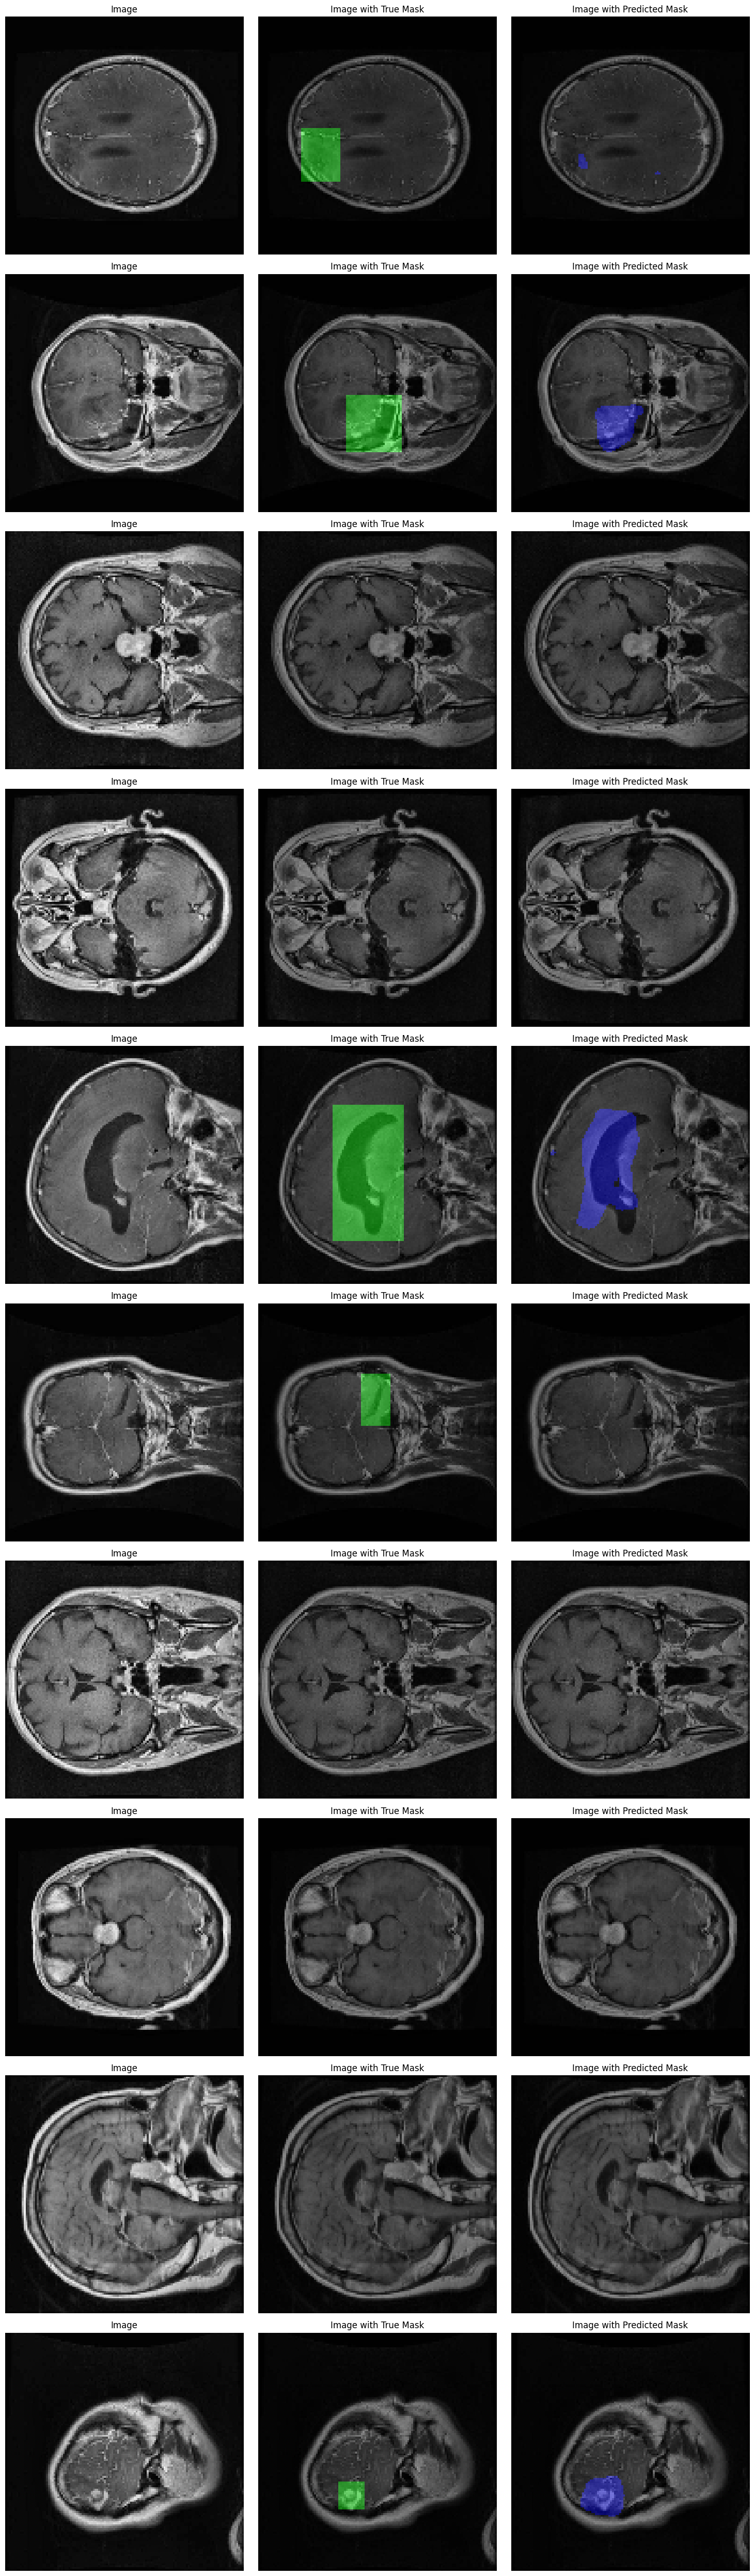

In [178]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_predictions_with_overlay(model, dataset, device, num_samples=1):
    model.eval()  # Set model to evaluation mode
    fig, axs = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

    # If we are showing a single sample, we need to adjust the axes array
    if num_samples == 1:
        axs = [axs]

    for i in range(num_samples):
        image, true_mask = dataset[i]
        image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

        # Forward pass to get the predicted mask
        with torch.no_grad():
            predicted_mask = model(image)

        # Move tensors back to CPU and remove batch dimension
        image = image.squeeze(0).cpu().numpy().transpose(1, 2, 0)
        true_mask = true_mask.cpu().numpy().squeeze()  # Ground truth mask
        predicted_mask = predicted_mask.squeeze(0).cpu().numpy().squeeze() > 0.5  # Predicted mask with threshold

        # If image is grayscale (single channel), convert it to 3 channels
        if image.shape[-1] == 1:
            image = np.repeat(image, 3, axis=-1)

        # Overlay mask on image by adding an alpha layer
        mask_overlay_true = np.zeros_like(image)
        mask_overlay_pred = np.zeros_like(image)

        # Set mask areas to red (True Mask) and green (Predicted Mask)
        mask_overlay_true[true_mask > 0] = [0, 255, 0]  # Red for true mask
        mask_overlay_pred[predicted_mask > 0] = [0, 0, 255]  # Green for predicted mask

        # Plot the original image
        axs[i][0].imshow(image)
        axs[i][0].set_title('Image')
        axs[i][0].axis('off')

        # Plot the image with the true mask highlighted
        axs[i][1].imshow(image)
        axs[i][1].imshow(mask_overlay_true, alpha=0.4)  # Overlay the true mask with transparency
        axs[i][1].set_title('Image with True Mask')
        axs[i][1].axis('off')

        # Plot the image with the predicted mask highlighted
        axs[i][2].imshow(image)
        axs[i][2].imshow(mask_overlay_pred, alpha=0.4)  # Overlay the predicted mask with transparency
        axs[i][2].set_title('Image with Predicted Mask')
        axs[i][2].axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions_with_overlay(model, val_dataset, device, num_samples=10)